# ***Step-by-Step Approach to RNN Modeling:***

**1. Setup and Data Preparation:**
   - Import necessary libraries: TensorFlow/Keras, numpy, pandas, FastAPI.
   - Load the dataset for sentiment analysis.
   - Preprocess the textual data and encode sentiment labels.


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


In [2]:
# Load the Twitter dataset (validation dataset)
columns=["ID","ENTITY","Label","Text"]
df = pd.read_csv('twitter_validation.csv',names=columns)

# Preview the data
print(df.head())


     ID     ENTITY       Label  \
0  3364   Facebook  Irrelevant   
1   352     Amazon     Neutral   
2  8312  Microsoft    Negative   
3  4371      CS-GO    Negative   
4  4433     Google     Neutral   

                                                Text  
0  I mentioned on Facebook that I was struggling ...  
1  BBC News - Amazon boss Jeff Bezos rejects clai...  
2  @Microsoft Why do I pay for WORD when it funct...  
3  CSGO matchmaking is so full of closet hacking,...  
4  Now the President is slapping Americans in the...  


In [5]:
import re

# Preprocessing function
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|\#', '', text)
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Clean the tweets
df['cleaned_tweet'] = df['Text'].apply(clean_text)

df.tail()

,ID,ENTITY,Label,Text,cleaned_tweet
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...,toronto is the arts and culture capital of can...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,this is actually a good move tot bring more vi...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...,today sucked so its time to drink wine n play ...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.,bought a fraction of microsoft today small wins
999,6960,johnson&johnson,Neutral,Johnson & Johnson to stop selling talc baby po...,johnson johnson to stop selling talc baby powd...


In [7]:
# Encode sentiment labels
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['Label'])

# Check the encoded labels
print(df[['Label', 'sentiment_encoded']].head())


        Label  sentiment_encoded
0  Irrelevant                  0
1     Neutral                  2
2    Negative                  1
3    Negative                  1
4     Neutral                  2


In [8]:
# Split the dataset into features (X) and labels (y)
X = df['cleaned_tweet']
y = df['sentiment_encoded']

# Perform stratified split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check class distribution
print(f"Train class distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test class distribution:\n{y_test.value_counts(normalize=True)}")


Train class distribution:
sentiment_encoded
2    0.28500
3    0.27750
1    0.26625
0    0.17125
Name: proportion, dtype: float64
Test class distribution:
sentiment_encoded
2    0.285
3    0.275
1    0.265
0    0.175
Name: proportion, dtype: float64


In [9]:
# Initialize the tokenizer
vocab_size = 10000  # Limit vocab size to the top 10,000 words
max_length = 50     # Max length of sequences
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have the same length
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

# Check the shape of padded sequences
print("Shape of padded training data:", X_train_padded.shape)
print("Shape of padded test data:", X_test_padded.shape)


Shape of padded training data: (800, 50)
Shape of padded test data: (200, 50)


# ***2. RNN Model Architecture:***
   - Choose an appropriate RNN architecture based on the dataset characteristics.
   - Define the architecture of the RNN model, including the number of layers and hidden units.


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

# Hyperparameters
vocab_size = 10000         # Size of vocabulary
embedding_dim = 128        # Embedding vector size
max_length = 50            # Max length of input sequences
num_classes = len(set(y_train))             # Number of sentiment classes (adjust if binary)

# Build the model
model = Sequential()

# Embedding layer converts integer tokens to dense vectors
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))

# Bidirectional LSTM layer to capture context from both directions
model.add(Bidirectional(LSTM(units=64, return_sequences=False)))

# Dropout for regularization to reduce overfitting
model.add(Dropout(0.5))

# Output layer with softmax activation for multi-class classification
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',  # Use binary_crossentropy if binary classification
    optimizer='adam',
    metrics=['accuracy']
)

# Show model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# ***3. Building the RNN:***
   - Build the RNN model using TensorFlow/Keras layers.
   - Compile the model with an appropriate loss function and optimizer.


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout

# Define hyperparameters
vocab_size = 10000       # Vocabulary size from tokenizer
embedding_dim = 128      # Size of the embedding vectors
max_length = 50          # Maximum length of input sequences
num_classes = len(set(y_train))  # Number of sentiment classes

# Initialize the Sequential model
model = Sequential()

# Add Embedding layer to map input tokens to dense vectors
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))

# Add Bidirectional LSTM layer to capture context from both directions
model.add(Bidirectional(LSTM(64)))

# Add Dropout layer for regularization
model.add(Dropout(0.5))

# Add Dense output layer with softmax activation for multi-class classification
model.add(Dense(num_classes, activation='softmax'))


In [14]:
model.compile(
    loss='sparse_categorical_crossentropy',  # Use if labels are integer encoded (not one-hot)
    optimizer='adam',
    metrics=['accuracy']
)


In [15]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# ***4. Model Training:***
   - Train the RNN model on the training data, specifying the number of epochs and batch size.
   - Monitor training progress and performance on validation data.


In [16]:
epochs = 10         # Number of passes over the entire training data
batch_size = 64     # Number of samples processed before model weights update


In [17]:
history = model.fit(
    X_train_padded,          # Preprocessed, padded training sequences
    y_train,                 # Corresponding training labels
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_padded, y_test),  # Validation data for monitoring
    verbose=1               # Print progress bar and metrics per epoch
)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.2579 - loss: 1.3819 - val_accuracy: 0.3350 - val_loss: 1.3610
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.3618 - loss: 1.3532 - val_accuracy: 0.4000 - val_loss: 1.3511
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.4295 - loss: 1.3300 - val_accuracy: 0.3750 - val_loss: 1.3399
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.4479 - loss: 1.2680 - val_accuracy: 0.4550 - val_loss: 1.3585
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.5356 - loss: 1.1864 - val_accuracy: 0.3950 - val_loss: 1.3064
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.6201 - loss: 1.0415 - val_accuracy: 0.4100 - val_loss: 1.3164
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.7281 - loss: 0.8139 - val_accuracy: 0.3800 - val_loss: 1.3694
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - accuracy: 0.8530 - loss: 0.5810 - val_accuracy: 0.

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,             # Stop after 3 epochs without improvement
    restore_best_weights=True
)

history = model.fit(
    X_train_padded,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9522 - loss: 0.2391 - val_accuracy: 0.3700 - val_loss: 1.6793
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9457 - loss: 0.2268 - val_accuracy: 0.4200 - val_loss: 1.7729
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.9794 - loss: 0.1344 - val_accuracy: 0.3900 - val_loss: 2.0323
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9838 - loss: 0.1059 - val_accuracy: 0.3850 - val_loss: 2.1194


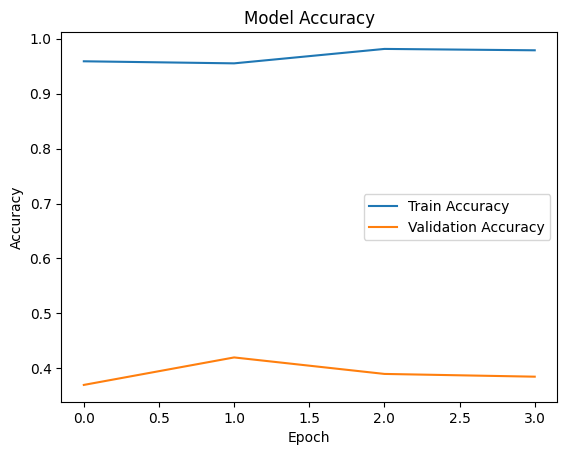

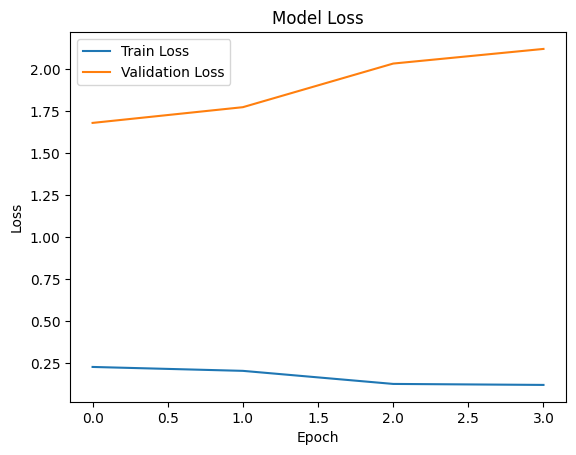

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# ***5. Model Evaluation:***
   - Evaluate the trained RNN model on the testing data using appropriate evaluation metrics.
   - Analyze the model's performance and identify areas for improvement.


In [20]:
import numpy as np

# Predict probabilities for each class
y_pred_prob = model.predict(X_test_padded)

# Convert probabilities to predicted class labels
y_pred = np.argmax(y_pred_prob, axis=1)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


In [21]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Get precision, recall, f1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

print("Class-wise Precision:", precision)
print("Class-wise Recall:", recall)
print("Class-wise F1-score:", f1)

# Detailed classification report
target_names = label_encoder.classes_  # Assuming you used LabelEncoder earlier
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names))


Test Accuracy: 0.3700
Class-wise Precision: [0.39130435 0.33103448 0.38888889 0.71428571]
Class-wise Recall: [0.25714286 0.90566038 0.12280702 0.18181818]
Class-wise F1-score: [0.31034483 0.48484848 0.18666667 0.28985507]

Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.39      0.26      0.31        35
    Negative       0.33      0.91      0.48        53
     Neutral       0.39      0.12      0.19        57
    Positive       0.71      0.18      0.29        55

    accuracy                           0.37       200
   macro avg       0.46      0.37      0.32       200
weighted avg       0.46      0.37      0.32       200



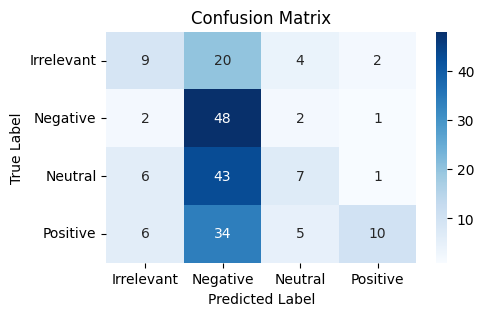

In [23]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,3))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# ***6. Fine-tuning and Optimization:***
   - Fine-tune the RNN model by adjusting hyperparameters and exploring optimization techniques.
   - Validate the optimized model's performance and compare it with baseline results.


In [24]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define optimizer with gradient clipping
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train_padded, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stop, lr_scheduler]
)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - accuracy: 0.9375 - loss: 0.2360 - val_accuracy: 0.4450 - val_loss: 2.0243 - learning_rate: 0.0010
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.9633 - loss: 0.1792 - val_accuracy: 0.4050 - val_loss: 1.9999 - learning_rate: 0.0010
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9784 - loss: 0.0997 - val_accuracy: 0.3750 - val_loss: 2.3593 - learning_rate: 0.0010
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9890 - loss: 0.0743
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9889 - loss: 0.0743 - val_accuracy: 0.3700 - val_loss: 2.5061 - learning_rate: 0.0010
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9830 - loss: 0.0599 - val_accuracy: 0.4100 - val_loss: 2.4940 - learning_rate: 5.0000e-04
